In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 20 20:24:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Install TensorTrade

In [ ]:
!python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git
!pip install ccxt
!pip install stable-baselines3
!pip install ta
!pip install pyyaml==5.4.1

# Load the TensorBoard notebook extension
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-9m5mo0ex
  Running command git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-9m5mo0ex
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 793 kB 28.5 MB/s 
     |████████████████████████████████| 1.6 MB 67.3 MB/s 
  Created wheel for tensortrade: filename=tensortrade-1.0.4.dev1-py3-none-any.whl size=136256 sha256=b83a52f8fffbfdaf8add7dc4f8f06f482b094568386fec8009828661220378a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-f68umaxr/wheels/f8/96/4d/142e37e09469abec8017a451809b175d5f64d0ce81cbe8d8ec
Successfully built tensortrade
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not curren

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 15.2 MB/s 
     |████████████████████████████████| 1.5 MB 95.6 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616800 sha256=724605b87bf158a9118b824124c6d531a35b70e0e54de5606a43fa27ee9da2fb
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.1
    Uninstalling gym-0.25.1:
      Successfully uninstalled gym-0.25.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28971 sha256=a2bea89586a8943687b5b5a64b0f7edeedacd2d099da58266055ccd584e6c794
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully bui

In [ ]:
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 291 kB/s 
     |████████████████████████████████| 62 kB 437 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


## Setup Data Fetching

In [ ]:
import pandas as pd
import tensortrade.env.default as default
import ta

import ccxt
from datetime import datetime, timedelta, time
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, MinMaxScaler

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USDT, BTC, ETH
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent

from stable_baselines3 import A2C, PPO

%matplotlib inline

In [ ]:
from tensortrade.data.cdd import CryptoDataDownload

import numpy as np
import pandas as pd
pd.options.mode.use_inf_as_na = True

def prepare_data(df):
    df['volume'] = np.int64(df['volume'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    return df

def fetch_data():
    cdd = CryptoDataDownload()
    bitfinex_data = cdd.fetch("Bitfinex", "USD", "BTC", "d")
    bitfinex_data = bitfinex_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    bitfinex_data = prepare_data(bitfinex_data)
    print(bitfinex_data)
    return bitfinex_data

def load_csv(filename):
    df = pd.read_csv('data/' + filename, skiprows=1)
    df.drop(columns=['symbol', 'volume_btc'], inplace=True)

    # Fix timestamp from "2019-10-17 09-AM" to "2019-10-17 09-00-00 AM"
    df['date'] = df['date'].str[:14] + '00-00 ' + df['date'].str[-2:]

    return prepare_data(df)


fetch_data()


            date          open          high       low         close  \
0     2015-02-09    224.220000    225.000000    215.40    220.610000   
1     2015-02-10    220.610000    223.880000    214.00    220.960000   
2     2015-02-11    220.960000    224.400000    218.10    219.190000   
3     2015-02-12    219.190000    223.200000    217.87    222.600000   
4     2015-02-13    222.390000    241.760000    221.46    236.000000   
...          ...           ...           ...       ...           ...   
2745  2022-08-16  24091.000000  24234.106237  23679.00  23856.000000   
2746  2022-08-17  23855.764643  24440.000000  23170.00  23332.485373   
2747  2022-08-18  23332.000000  23600.000000  23115.00  23204.000000   
2748  2022-08-19  23194.000000  23199.000000  20790.00  20835.000000   
2749  2022-08-20  20832.000000  21187.000000  20794.00  21100.000000   

         volume  
0       6493501  
1       6402350  
2       4268986  
3       2468883  
4       6806972  
...         ...  
2745   66

,date,open,high,low,close,volume
0,2015-02-09,224.220000,225.000000,215.40,220.610000,6493501
1,2015-02-10,220.610000,223.880000,214.00,220.960000,6402350
2,2015-02-11,220.960000,224.400000,218.10,219.190000,4268986
3,2015-02-12,219.190000,223.200000,217.87,222.600000,2468883
4,2015-02-13,222.390000,241.760000,221.46,236.000000,6806972
...,...,...,...,...,...,...
2745,2022-08-16,24091.000000,24234.106237,23679.00,23856.000000,66040849
2746,2022-08-17,23855.764643,24440.000000,23170.00,23332.485373,142939854
2747,2022-08-18,23332.000000,23600.000000,23115.00,23204.000000,70231799
2748,2022-08-19,23194.000000,23199.000000,20790.00,20835.000000,198628383


Download data with a defined date range

In [ ]:
#BTC/USD data, volume = volume of BTC
data = fetch_data()

start_date = '2015-02-09'
end_date = '2022-07-16'
after_start_date = data["date"] >= start_date
before_end_date = data["date"] <= end_date
between_two_dates = after_start_date & before_end_date
# Using pandas.DataFrame.loc to Filter Rows by Dates
data = data.loc[between_two_dates]


            date          open          high       low         close  \
0     2015-02-09    224.220000    225.000000    215.40    220.610000   
1     2015-02-10    220.610000    223.880000    214.00    220.960000   
2     2015-02-11    220.960000    224.400000    218.10    219.190000   
3     2015-02-12    219.190000    223.200000    217.87    222.600000   
4     2015-02-13    222.390000    241.760000    221.46    236.000000   
...          ...           ...           ...       ...           ...   
2745  2022-08-16  24091.000000  24234.106237  23679.00  23856.000000   
2746  2022-08-17  23855.764643  24440.000000  23170.00  23332.485373   
2747  2022-08-18  23332.000000  23600.000000  23115.00  23204.000000   
2748  2022-08-19  23194.000000  23199.000000  20790.00  20835.000000   
2749  2022-08-20  20832.000000  21187.000000  20794.00  21100.000000   

         volume  
0       6493501  
1       6402350  
2       4268986  
3       2468883  
4       6806972  
...         ...  
2745   66

In [ ]:
from ta import add_all_ta_features

features = data.copy()

features = add_all_ta_features(
    features, open="open", high="high", low="low", close="close", volume="volume", fillna=True)



/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [ ]:
features.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'tren

Visualising data using candlestick chart

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

candles = data.copy()

# set date as index
candles = candles.set_index('date')

candlesticks = go.Candlestick(
    x=candles.index,
    open=candles['open'],
    high=candles['high'],
    low=candles['low'],
    close=candles['close'],
    showlegend=False
)

volume_bars = go.Bar(
    x=candles.index,
    y=candles['volume'],
    showlegend=False,
    marker={
        "color": "rgba(128,128,128,0.5)",
    }
)

fig = go.Figure(candlesticks)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(candlesticks, secondary_y=True)
fig.add_trace(volume_bars, secondary_y=False)
fig.update_layout(title="BTC/USDT Canndlestick Price with volume", height=800)
fig.update_yaxes(title="Volume", secondary_y=True, showgrid=True)
fig.update_yaxes(title="Price", secondary_y=False, showgrid=False)
fig.update_xaxes(title="Year")



fig.show()

Understanding data type and statistic

In [ ]:
data.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [ ]:
import plotly.express as px
fig = px.line(data, y=['open', 'high', 'low', 'close'], labels={'index': 'Year in observation number', 'value':'BTC price'}) 
fig.show()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



Training and testing split of the data with visualisation

In [ ]:
import numpy as np
import pandas as pd
import random
import copy
import time

import plotly
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import iplot

plot = data.copy()

# convert date format
plot['date'] = pd.to_datetime(plot['date'])

# set date as index
plot = plot.set_index('date')


# 0.7 split limit
split_limit = int(len(plot) * 0.909)

plot_train = plot.iloc[:split_limit]
plot_test = plot.iloc[split_limit:]


def plot_train_test(train, test, date_split):
    data = [Candlestick(x=train.index, open=train['open'], high=train['high'], low=train['low'], close=train['close'], name='train'),
            Candlestick(x=test.index, open=test['open'], high=test['high'], low=test['low'], close=test['close'], name='test')]
    
    layout = { 'shapes': [{'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}],
               'annotations': [{'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
                               {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}]}



    figure = Figure(data=data, layout=layout)

    figure.update_layout(
    title="Data Train/Test Split Visulisation",
    xaxis_title="Year",
    yaxis_title="Price",
    legend_title="10:1 Train/Test Split")

    iplot(figure)

plot_train_test(plot_train, plot_test, plot_train.iloc[-1].name)


Exploratory data analysis

Analysis 1:

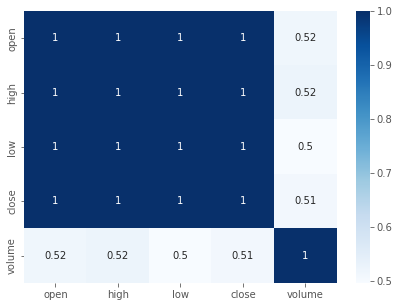

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.heatmap(data.corr(),cmap='Blues',annot=True)


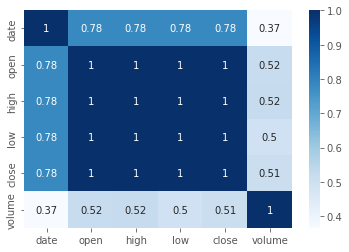

In [ ]:
data3 = data.copy()

data3.date=pd.to_datetime(data3.date)
data3.date=pd.to_numeric(data3.date)


sns.heatmap(data3.corr(),cmap='Blues',annot=True)


plt.savefig('ohlcv_correlation')

Analysis 2:

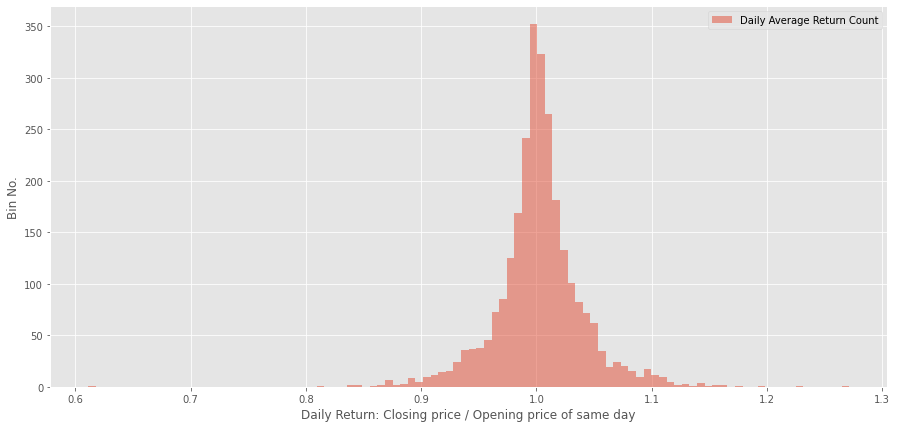

In [ ]:
data['average_return'] = data['close']/data['open']

data['average_return'].hist(bins = 100, label = 'Daily Average Return Count', alpha = 0.5, figsize = (15,7))

plt.ylabel('Bin No.')
plt.xlabel('Daily Return: Closing price / Opening price of same day')
plt.legend()

plt.savefig('dailyreturn_histogram')

In [ ]:
data[data['average_return']>1].shape

(1454, 7)

In [ ]:
data[data['average_return']==1].shape

(14, 7)

In [ ]:
data[data['average_return']<1].shape



(1247, 7)

Analysis 3:

In [ ]:
data.date=pd.to_datetime(data.date)

data.date

0      2015-02-09
1      2015-02-10
2      2015-02-11
3      2015-02-12
4      2015-02-13
          ...    
2710   2022-07-12
2711   2022-07-13
2712   2022-07-14
2713   2022-07-15
2714   2022-07-16
Name: date, Length: 2715, dtype: datetime64[ns]

In [ ]:
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')

In [ ]:

data['date'] = pd.DatetimeIndex(data['date'])

data = data.set_index('date')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



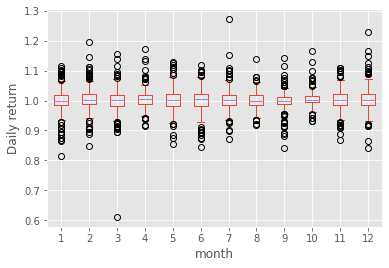

In [ ]:
data.set_index(data.index.month, append=True)['average_return'].unstack().plot.box()
plt.ylabel('Daily return')
plt.xlabel('month')

plt.savefig('boxplot_month')

In [ ]:
data.head(1)

,open,high,low,close,volume,average_return
date,,,,,,
2015-02-09,224.22,225.0,215.4,220.61,6493501,0.9839
